# TP Coding Convolutional Neural Networks in Pytorch - part 1

Practical work originally created by Alasdair Newson (https://sites.google.com/site/alasdairnewson/)

For any remark or suggestion, please feel free to contact me at:

- loic.lefolgoc@telecom-paris.fr

### Objective:

We want to implement a Convolutional Neural Network (CNN) for image recognition. For this we will use two well-known datasets, the first simpler and the second more complicated :

- MNIST (images of digits)
- CIFAR-10 dataset https://www.cs.toronto.edu/~kriz/cifar.html.

The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.

<br>We will first code the simple ConvNet described below using the Pytorch environment : https://pytorch.org/.

- The input of the CNN is a set of (3,m,n) image tensors (m and n depend on the dataset).
- We apply
    - a Convolutional layer of 32 filters of shape (3,3), with stride (1,1) and padding='same' (i.e. we apply zero-padding)
    - additive biases
    - a ReLu activation function
    - a Convolutional layer of 32 filters of shape (3,3), with stride (1,1) and padding='same' (i.e. we apply zero-padding)
    - additive biases
    - a ReLu activation function
    - a Max Pooling Layer of shape (2,2) and stride (2,2) (i.e. we reduce by two the size in each dimension)
    - We then Flatten the data (reduce them to a vector in order to be able to apply a Fully-Connected layer to it)
    - A softmax activation function which outputs are the $P(y_c | X)$ (multi-class problem)


<IMG SRC='https://drive.google.com/uc?export=view&id=10xVi1LejX5TAI-tuOQM-UrSrNYa9gi0q'>
    
You should use the "SAME" border conditions.
    
### Your task:
You need to add the missing parts in the code (parts between # --- START CODE HERE and # --- END CODE HERE)

# Load packages

In [34]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms

### CNN model in Pytorch

There are several ways to write a CNN model in pytorch. In this lab, you will be using the _Sequential_ class of pytorch (similarly to Tensorflow). We will see the syntax further on.



# Import data

We first import the MNIST dataset. The training set is imported in `mnist_trainset` and the test set in `mnist_testset`.

In practice, training on `mnist_trainset` takes too much time for this practical work. For this reason, we define a smaller training set (`mnist_trainset_reduced`) with a random subset of images. We will use `mnist_trainset_reduced` when training.

In [35]:
# Convert input to Pytorch tensors (ToTensor includes a rescaling from the range [0,255] to [0.0,1.0])
input_transform=transforms.Compose([transforms.ToTensor()])

# Download MNIST training data
mnist_trainset = datasets.MNIST(root='./data',train=True,download=True,transform=input_transform)
print(mnist_trainset)

# Download test dataset
mnist_testset = datasets.MNIST(root='./data',train=False,download=True,transform=input_transform)

# Create data loader with smaller dataset size
max_mnist_size = 2000
mnist_trainset_reduced = torch.utils.data.random_split(mnist_trainset, [max_mnist_size, len(mnist_trainset)-max_mnist_size])[0]

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )


We also make a direct access to the training and test data as `torch` tensors. We will use them for visualization purposes and to compute the final training/test accuracies.

In [36]:
# Extract the actual data and labels
X_train = torch.unsqueeze(mnist_trainset.data,axis=1)[mnist_trainset_reduced.indices]/255.0
Y_train = mnist_trainset.targets[mnist_trainset_reduced.indices]
X_test = torch.unsqueeze(mnist_testset.data,axis=1)/255.0
Y_test = mnist_testset.targets

## Exploring the data

We can explore the dataset `mnist_trainset` manually, although when we train the model, we will use the ```DataLoader``` of Pytorch (see later).

The images are contained in a sub-structure of ```mnist_trainset``` called ```data```. The labels are contained in another sub-structure of ```mnist_trainset``` called ```targets```. Note that these are kept in their native format (the transformations are not applied to them), so to use them we have to apply the transformation manually, as above.

__NOTE__ In general, if you want to find out what a structure contains, use the command ```dir()```, this will give you a list of the sub-structures.

__NOTE__ `mnist_trainset_reduced` is a `Subset` object rather than a `Dataset` object. We cannot call `.data` and `.target` directly on it, although we can pass it as argument to a `DataLoader`.

In [37]:
print(dir(mnist_trainset))

print("Size of training data : ", mnist_trainset.data.shape)
print("Size of training labels : ", mnist_trainset.targets.shape)


['__add__', '__annotations__', '__class__', '__class_getitem__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__len__', '__lt__', '__module__', '__ne__', '__new__', '__orig_bases__', '__parameters__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__slots__', '__str__', '__subclasshook__', '__weakref__', '_check_exists', '_check_legacy_exist', '_format_transform_repr', '_is_protocol', '_load_data', '_load_legacy_data', '_repr_indent', 'class_to_idx', 'classes', 'data', 'download', 'extra_repr', 'mirrors', 'processed_folder', 'raw_folder', 'resources', 'root', 'target_transform', 'targets', 'test_data', 'test_file', 'test_labels', 'train', 'train_data', 'train_labels', 'training_file', 'transform', 'transforms']
Size of training data :  torch.Size([60000, 28, 28])
Size of training labels :  torch.Size([60000])


The mnist dataset has 10 classes. These are the following :

In [38]:
mnist_list = [ '0', '1','2','3','4','5','6','7','8','9']

## Display some of the images

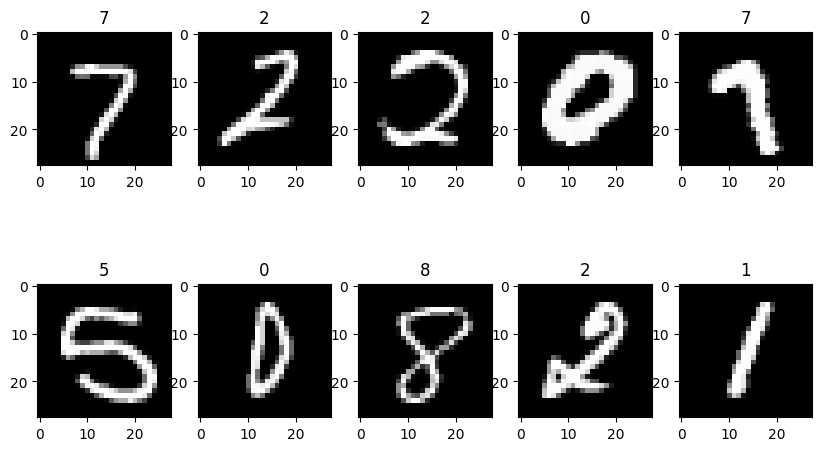

In [39]:
plt.figure(figsize=(10, 6))
for idx in range(0,10):
    plt.subplot(2, 5, idx+1)
    rand_ind = np.random.randint(0,mnist_trainset.data.shape[0])
    plt.imshow(mnist_trainset.data[rand_ind,:,:],cmap='gray')
    plt.title(mnist_list[int(mnist_trainset.targets[rand_ind])])

# Defining the model for MNIST

We will now define the simple CNN described above, for use with MNIST. The input of the CNN is a set of (28,28,1) image tensors. We apply the following layers:

    - a Convolutional layer of 32 filters of shape (3,3), with stride (1,1) and padding='same'
    - a ReLu activation function
    
    - a Convolutional layer of 32 filters of shape (3,3), with stride (1,1) and padding='same'
    - a ReLu activation function
    - a Max Pooling Layer of shape (2,2) and stride (2,2) (i.e. we reduce by two the size in each dimension)
    
    - We then Flatten the data: reduce them to a vector in order to be able to apply a Fully-Connected layer to it
    - Dense (fully connected) layer. Note, you will have to determine the input size, that is to say the number of elements after the last Max Pooling layer.

__VERY IMPORTANT NOTE !!!__

Pytorch carries out the softmax which we would expect at the end of our network automatically in the loss function that we will use, so there is no need to add it. Nevertheless, you must understand that the network output is a vector (of logits) which is _not_ normalised to be a probability distribution. This will be important later on.

Now, we define the following hyper-parameters of the model :

In [40]:
learning_rate = 0.01
n_epochs = 10
batch_size = 64
nb_classes = int(mnist_trainset.targets.max()+1)

nb_filters = 32       # number of convolutional filters to use
kernel_size = (3, 3)  # convolution kernel size
pool_size = (2, 2)    # size of pooling area for max pooling

# --- Size of the successive layers
n_h_0 = 1             # greyscale input images
n_h_1 = nb_filters
n_h_2 = nb_filters

# Model 1 : defining a CNN with the Sequential API of Pytorch for MNIST

We are now going to create the CNN with Pytorch.

The Sequential approach is quite similar to that of Tensorflow. To define a model, just write:

```my_model = torch.nn.Sequential( first_layer, second_layer, ...)```

Each layer must be a function imported from the Pytorch. You can use the following functions:

- ```torch.nn.Conv2d()```
- ```torch.nn.ReLU()```
- ```torch.nn.MaxPool2d()```
- ```torch.nn.Flatten()```
- ```torch.nn.Linear()```

Look at the documentation online to find the correct parameters. For example:

- https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html


In [41]:
# BEGIN STUDENT CODE
mnist_model = torch.nn.Sequential(
    nn.Conv2d(in_channels=n_h_0, out_channels=n_h_1, kernel_size=kernel_size, stride=1, padding='same'),
    nn.ReLU(),
    nn.Conv2d(in_channels=n_h_1, out_channels=n_h_2, kernel_size=kernel_size, stride=1, padding='same'),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=pool_size, stride=2),
    nn.Flatten(),
    nn.Linear(n_h_2 * 14 * 14, 10)
)
# END STUDENT CODE

## Define dataloader

We use the ```torch.utils.data.DataLoader``` function of Pytorch to easily iterate over mini-batches of data. ```torch.utils.data.DataLoader``` is a useful function to extract batches of data from a dataset, applying the transformations which we have specified (conversion to Pytorch tensor, normalisation etc).

We will train using the smaller training set, `mnist_trainset_reduced`.

In [42]:
mnist_train_loader = torch.utils.data.DataLoader(mnist_trainset_reduced, batch_size=batch_size, shuffle=True)

## Define loss function and optimiser

Pytorch provides an easy way to define the loss criterion to optimise. The syntax is (considering that the Adam optimiser is used):

- ```criterion = torch.nn.BCELoss()``` or ```criterion = torch.nn.CrossEntropyLoss()```, etc., depending on your problem.
- ```optimizer = torch.optim.Adam(mnist_model.parameters(), lr=learning_rate)```

Fill in the following code, choosing the correct criterion to optimise. For the criterion, the individual loss over individual data samples can be aggregated into the total loss in several ways. Choose `reduction='sum'`, which takes the sum of individual losses.

In [43]:
# BEGIN STUDENT CODE
criterion = nn.CrossEntropyLoss(reduction='sum')
optimizer = optim.Adam(mnist_model.parameters(), lr=learning_rate)
# END STUDENT CODE

## CNN prediction conversion

We recall here that the output of the classification CNN in Pytorch is a vector which is __NOT__ normalised to be a probability distribution. Therefore, for the purposes of finding the prediction of the CNN, we create a function which first converts an input vector to a probability distribution, and then determines the most likely class for each vector. The output should be, for each vector, an integer between 0 and (number of classes) $-1$.

The inputs to this function will be Pytorch tensors, so you can use the following Pytorch functions on them :

- ```torch.nn.Softmax()```
- ```torch.argmax()```

Create this function now.

In [44]:
def vector_to_class(x):
  # BEGIN STUDENT CODE
  y = torch.argmax(nn.Softmax(dim=1)(x), dim=1)
  # END STUDENT CODE
  return y

## Accuracy

Now, define a function which calculates the accuracy of the output of the neural network, with respect to the input labels. We consider that the input is a vector of class numbers (similar to the output of `vector_to_class`, but converted to a numpy array).

In [45]:
def cnn_accuracy(predict,labels):
  # BEGIN STUDENT CODE
  accuracy = np.asarray(labels==predict).mean()
  # END STUDENT CODE
  return accuracy

## Training the model

Now, we carry out the actual training of the model.

In [47]:
train_losses=[]
valid_losses=[]

for epoch in tqdm(range(0,n_epochs)):
  train_loss=0.0
  all_labels = []
  all_predicted = []

  for batch_idx, (imgs, labels) in enumerate(mnist_train_loader):
    # pass the samples through the network
    predict = mnist_model(imgs) # FILL IN STUDENT
    # apply loss function
    loss = criterion(predict, labels) # FILL IN STUDENT
    # set the gradients back to 0
    optimizer.zero_grad() # FILL IN STUDENT
    # backpropagation
    loss.backward() # FILL IN STUDENT
    # parameter update
    optimizer.step() # FILL IN STUDENT
    # compute the train loss
    train_loss += loss.item()
    # store labels and class predictions
    all_labels.extend(labels.tolist())
    all_predicted.extend(vector_to_class(predict).tolist())

  print('Epoch:{}\n\tTrain Loss:{:.4f}'.format(epoch,train_loss/len(mnist_train_loader.dataset)))

  # calculate accuracy
  print('\tAccuracy:{:.2%}\n'.format(cnn_accuracy(np.array(all_predicted),np.array(all_labels))))

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch:0
	Train Loss:0.0160
	Accuracy:99.60%

Epoch:1
	Train Loss:0.0187
	Accuracy:99.20%

Epoch:2
	Train Loss:0.0159
	Accuracy:99.45%

Epoch:3
	Train Loss:0.0249
	Accuracy:99.05%

Epoch:4
	Train Loss:0.0148
	Accuracy:99.50%

Epoch:5
	Train Loss:0.0322
	Accuracy:99.05%

Epoch:6
	Train Loss:0.0419
	Accuracy:98.70%

Epoch:7
	Train Loss:0.0307
	Accuracy:99.00%

Epoch:8
	Train Loss:0.0297
	Accuracy:98.75%

Epoch:9
	Train Loss:0.0300
	Accuracy:99.00%



<br> Let's compute the final training and test accuracies:

In [48]:
# Calculate accuracy on the training set and the test set

# BEGIN FILL IN STUDENT (use X_train, Y_train, X_test, Y_test)
predict_train = vector_to_class(mnist_model(X_train))
predict_test = vector_to_class(mnist_model(X_test))

train_accuracy = cnn_accuracy(predict_train, Y_train)
test_accuracy = cnn_accuracy(predict_test, Y_test)
# END FILL IN STUDENT

print(f"Train Accuracy: {train_accuracy:.2%}")
print(f"Test Accuracy: {test_accuracy:.2%}")

Train Accuracy: 99.40%
Test Accuracy: 93.47%


Visual results : 


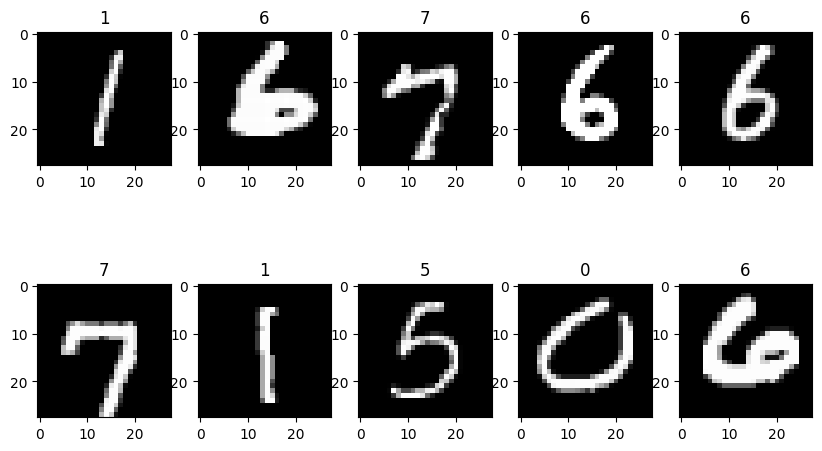

In [49]:
print("Visual results : ")

plt.figure(figsize=(10, 6))
for idx in range(0,10):
    plt.subplot(2, 5, idx+1)
    rand_ind = np.random.randint(0,X_test.shape[0])
    test_img = torch.unsqueeze(X_test[rand_ind,:,:,:],axis=1)
    predicted_class = vector_to_class(mnist_model(test_img))
    plt.imshow(test_img.squeeze(),cmap='gray')
    plt.title(mnist_list[int(predicted_class)])

# Model 2: create a CNN on CIFAR10

We are now going to train the same network architecture on a more difficult dataset : CIFAR-10

First, we import the CIFAR-10 data and carry out some pre-processing :

In [50]:
# Convert input to Pytorch tensors
input_transform=transforms.Compose( [transforms.ToTensor()])

# Download CIFAR-10 training data
cifar_trainset = datasets.CIFAR10(root='./data',train=True,download=True,transform=input_transform)
print(cifar_trainset)

# Download test dataset
cifar_testset = datasets.CIFAR10(root='./data',train=False,download=True,transform=input_transform)

# Create data loader with smaller dataset size
max_cifar_size = 5000
cifar_trainset_reduced = torch.utils.data.random_split(cifar_trainset, [max_cifar_size, len(cifar_trainset)-max_cifar_size])[0]

Files already downloaded and verified
Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )
Files already downloaded and verified


In [51]:
# Extract the actual data and labels
X_train = torch.from_numpy(cifar_trainset.data[cifar_trainset_reduced.indices]/255.0).float().permute(0,3,1,2)
Y_train = torch.tensor(cifar_trainset.targets, dtype=torch.uint8)[cifar_trainset_reduced.indices]
X_test = torch.from_numpy(cifar_testset.data/255.0).float().permute(0,3,1,2)
Y_test = torch.tensor(cifar_testset.targets, dtype=torch.uint8)

nb_channels = X_train.shape[1]

In [52]:
# The CIFAR10 categories
cifar_10_list = [ 'airplane', 'automobile','bird','cat','deer','dog','frog','horse','ship','truck']

## Display some of the images

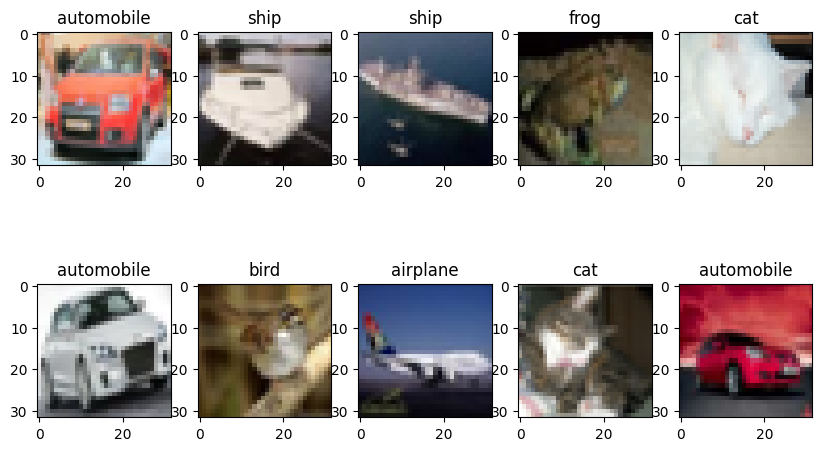

In [53]:
plt.figure(figsize=(10, 6))
for idx in range(0,10):
    plt.subplot(2, 5, idx+1)
    rand_ind = np.random.randint(0,X_test.shape[0])
    plt.imshow(X_test[rand_ind,:,:,:].permute(1,2,0))
    plt.title(cifar_10_list[int(Y_test[rand_ind])])

# Define the architecture again, for CIFAR-10

In this case, we are going to add a layer because the data is more complex. Therefore, we use the following architecture :

    - a Convolutional layer of 32 filters of shape (3,3), with stride (1,1) and padding='same'
    - additive biases
    - a ReLu activation function
    
    - a Convolutional layer of 32 filters of shape (3,3), with stride (1,1) and padding='same'
    - additive biases
    - a ReLu activation function
    - a Max Pooling Layer of shape (2,2) and stride (2,2) (i.e. we reduce by two the size in each dimension)
    
    - a Convolutional layer of 32 filters of shape (3,3), with stride (1,1) and padding='same'
    - additive biases
    - a ReLu activation function
    - a Max Pooling Layer of shape (2,2) and stride (2,2) (i.e. we reduce by two the size in each dimension)

    - a Convolutional layer of 32 filters of shape (3,3), with stride (1,1) and padding='same'
    - additive biases
    - a ReLu activation function
    - a Max Pooling Layer of shape (2,2) and stride (2,2) (i.e. we reduce by two the size in each dimension)
    
    - We then Flatten the data (reduce them to a vector in order to be able to apply a Fully-Connected layer to it)
    - Dense (fully connected) layer

In [54]:
learning_rate = 0.01
n_epochs = 25
batch_size = 256
nb_classes = 10

nb_filters = 32         # number of convolutional filters to use
kernel_size = (3, 3)    # convolution kernel size
pool_size = (2, 2)      # size of pooling area for max pooling

# --- Size of the successive layers
n_h_0 = nb_channels
n_h_1 = nb_filters
n_h_2 = nb_filters
n_h_3 = nb_filters

Now, modify the previous code (you can copy/paste/modify the necessary parts) to define the model for CIFAR-10.

In [55]:
# BEGIN STUDENT CODE
cifar_model = torch.nn.Sequential(
    nn.Conv2d(in_channels=n_h_0, out_channels=n_h_1, kernel_size=kernel_size, stride=1, padding='same', bias=True),
    nn.ReLU(),
    nn.Conv2d(in_channels=n_h_1, out_channels=n_h_2, kernel_size=kernel_size, stride=1, padding='same', bias=True),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=pool_size, stride=2),
    nn.Conv2d(in_channels=n_h_2, out_channels=n_h_3, kernel_size=kernel_size, stride=1, padding='same', bias=True),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=pool_size, stride=2),
    nn.Flatten(),
    nn.Linear(n_h_3 * 8 * 8, 10)
)

cifar_train_loader = torch.utils.data.DataLoader(cifar_trainset_reduced, batch_size=batch_size, shuffle=True)
criterion = nn.CrossEntropyLoss(reduction='sum')
optimizer = optim.Adam(cifar_model.parameters(), lr=learning_rate)
# END STUDENT CODE

Now, carry out training on the CIFAR-10 dataset (use the previous code as an example).

In [56]:
# BEGIN STUDENT CODE
train_losses=[]
valid_losses=[]

for epoch in tqdm(range(0,n_epochs)):
  train_loss=0.0
  all_labels = []
  all_predicted = []

  for batch_idx, (imgs, labels) in enumerate(cifar_train_loader):
    # pass the samples through the network
    predict = cifar_model(imgs) # FILL IN STUDENT
    # apply loss function
    loss = criterion(predict, labels) # FILL IN STUDENT
    # set the gradients back to 0
    optimizer.zero_grad() # FILL IN STUDENT
    # backpropagation
    loss.backward() # FILL IN STUDENT
    # parameter update
    optimizer.step() # FILL IN STUDENT
    # compute the train loss
    train_loss += loss.item()
    # store labels and class predictions
    all_labels.extend(labels.tolist())
    all_predicted.extend(vector_to_class(predict).tolist())

  print('Epoch:{}\n\tTrain Loss:{:.4f}'.format(epoch,train_loss/len(cifar_train_loader.dataset)))

  # calculate accuracy
  print('\tAccuracy:{:.2%}\n'.format(cnn_accuracy(np.array(all_predicted),np.array(all_labels))))
# END STUDENT CODE

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch:0
	Train Loss:2.2590
	Accuracy:16.58%

Epoch:1
	Train Loss:1.9253
	Accuracy:31.26%

Epoch:2
	Train Loss:1.7267
	Accuracy:39.66%

Epoch:3
	Train Loss:1.5871
	Accuracy:43.32%

Epoch:4
	Train Loss:1.4953
	Accuracy:47.56%

Epoch:5
	Train Loss:1.4183
	Accuracy:50.44%

Epoch:6
	Train Loss:1.3766
	Accuracy:51.06%

Epoch:7
	Train Loss:1.2633
	Accuracy:55.46%

Epoch:8
	Train Loss:1.2118
	Accuracy:57.42%

Epoch:9
	Train Loss:1.1776
	Accuracy:58.78%

Epoch:10
	Train Loss:1.0922
	Accuracy:62.14%

Epoch:11
	Train Loss:1.0122
	Accuracy:64.60%

Epoch:12
	Train Loss:0.9851
	Accuracy:66.02%

Epoch:13
	Train Loss:0.9349
	Accuracy:67.00%

Epoch:14
	Train Loss:0.8705
	Accuracy:68.72%

Epoch:15
	Train Loss:0.8146
	Accuracy:71.64%

Epoch:16
	Train Loss:0.7482
	Accuracy:73.02%

Epoch:17
	Train Loss:0.6407
	Accuracy:77.64%

Epoch:18
	Train Loss:0.5729
	Accuracy:79.64%

Epoch:19
	Train Loss:0.5433
	Accuracy:81.06%

Epoch:20
	Train Loss:0.4762
	Accuracy:83.68%

Epoch:21
	Train Loss:0.4384
	Accuracy:85.06%

Print the training and test accuracy (use the previous code as an example):

In [57]:
# Calculate accuracy on the training set and the test set

# BEGIN FILL IN STUDENT (use X_train, Y_train, X_test, Y_test)
predict_train = vector_to_class(cifar_model(X_train))
predict_test = vector_to_class(cifar_model(X_test))

train_accuracy = cnn_accuracy(vector_to_class(cifar_model(X_train)), Y_train)
test_accuracy = cnn_accuracy(vector_to_class(cifar_model(X_test)), Y_test)
# END STUDENT CODE

print(f"Train Accuracy: {train_accuracy:.2%}")
print(f"Test Accuracy: {test_accuracy:.2%}")

Train Accuracy: 90.38%
Test Accuracy: 45.74%


 What do you think about the results (better or worse than MNIST) ? Why do you think this is ? How could you improve the results ?

><div class="alert alert-block alert-success"><b>Answer:</b>
>
>* Results are <b>worse than MNIST</b>, especially for test set, but also slightly for the train set. We have a clear <b>overfitting</b>
>* Possible reasons are that in the CIFAR dataset :
>   * images are <b>colored</b>
>   * images have a <b>background</b> that can make more difficult to isolate the object we want to classify
>* In order to improve our model, we could:
>   * try a <b>data augmentation</b> for the train set such as flipping or miroring some images to help our model generalizing
>   * use some <b>regularization</b> techniques like <b>dropout or weight decay</b>, to prevent the overfitting we saw here
>   * use a <b>more advance architecture</b> (ResNet for eg.)
></div>

# Visualising the convolutional weights

You can explore the network parameters easily with Pytroch. Indeed, your model ```cifar_model``` is simply a list of layers, thus you can access the first layer with :
- ```cifar_model[0]```

If you want to find out the contents of this layer, use :

```dir(cifar_model[0])```

In particular, the convolutional weights are contained in the ```weights``` sub-structure (a multi-dimensional array). Note that this weight's size is :

- $[n_{filters}, n_{channels}, y_{size}, x_{size}]$

Now, display all (32) trained filters of the first convolutional layer, taking only the first channel of each filter :

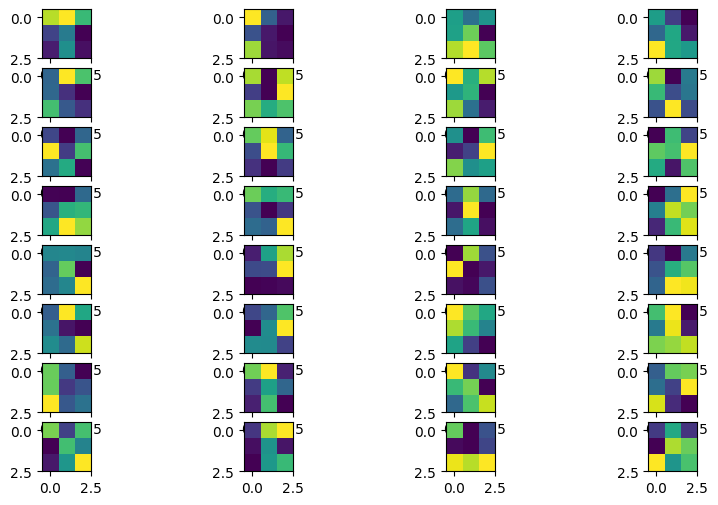

In [59]:
plt.figure(figsize=(10, 6))
for num in range(0,32):
    plt.subplot(8, 4, num+1)
    # --- START CODE HERE
    plt.imshow((cifar_model[0].weight[num,:,:,0]).detach().numpy(),cmap='viridis')
    # --- END CODE HERE

What do you think ? Pretty incomprehensible no ? Do not spend too long trying to interpret these filters, that way madness lies.

So, it seems that understanding a CNN by just looking at the filters is an exercise in futility. How can we do better ? Well, take a look at part 2 of the lab !

# Evaluation

To evaluate the work, you should rate the code for
- 1) MNIST : Defining the first model : 3 points
- 2) MNIST : Compiling and training the first model : 1 point
- 3) CIFAR10 : Defining the second model : 3 points
- 4) CIFAR10 : Compiling and training the second model : 1 point
- 5) Calculating ```predicted_class``` : 1 point
- 6) Correctly visualising the weights : 1 point


Total over 10 points. For the questions with three points :
- 1 point if partially correct
- 2 points if correct code but does not give the expected results. Be careful, sometimes the training might get stuck quickly by bad luck : restart the code a few times to make sure it is indeed a bug.
- 3 points for correct code and correct execution